In [12]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

def clean_and_parse_logs(logs_str):
    if isinstance(logs_str, str):
        logs_str = logs_str.strip('"').replace('""', '"')
        try:
            return json.loads(logs_str)
        except json.JSONDecodeError:
            return None
    return None

def calculate_duration(logs_str):
    logs = clean_and_parse_logs(logs_str)
    if logs is None:
        return None

    start_ts, end_ts = None, None
    for log in logs:
        if log.get("message") == "Task Specification: Start":
            start_ts = log["ts"]
        elif log.get("message") == "Task Specification: End":
            end_ts = log["ts"]
    
    if start_ts is not None and end_ts is not None:
        return (end_ts - start_ts) / 1000  # Convert ms to seconds
    return None

# Calculate average duration and plot
def calculate_average_duration(path: str):
    base_file = path.split(".")[0]
    processed_data_output_path=base_file + "_processed.csv"
    average_duration_output_path=base_file + "_average.csv"
    df = pd.read_csv(path, delimiter='$')
    df['task_duration'] = df['logs'].apply(calculate_duration)
    df.drop(columns=['logs'], inplace=True)
    df.to_csv(processed_data_output_path, index=False)
    average_duration_per_worker = df.groupby('worker_id')['task_duration'].mean().reset_index()
    average_duration_per_worker.to_csv(average_duration_output_path, index=False)
    plt.figure(figsize=(12, 6))
    plt.plot(average_duration_per_worker['worker_id'], average_duration_per_worker['task_duration'], marker='o', linestyle='-', color='blue')
    for i, row in average_duration_per_worker.iterrows():
        plt.annotate(str(row['worker_id']), (row['worker_id'], row['task_duration']), 
                    textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
    plt.title(base_file.split('/')[1])
    plt.xlabel('Worker ID')
    plt.ylabel('Task Duration')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


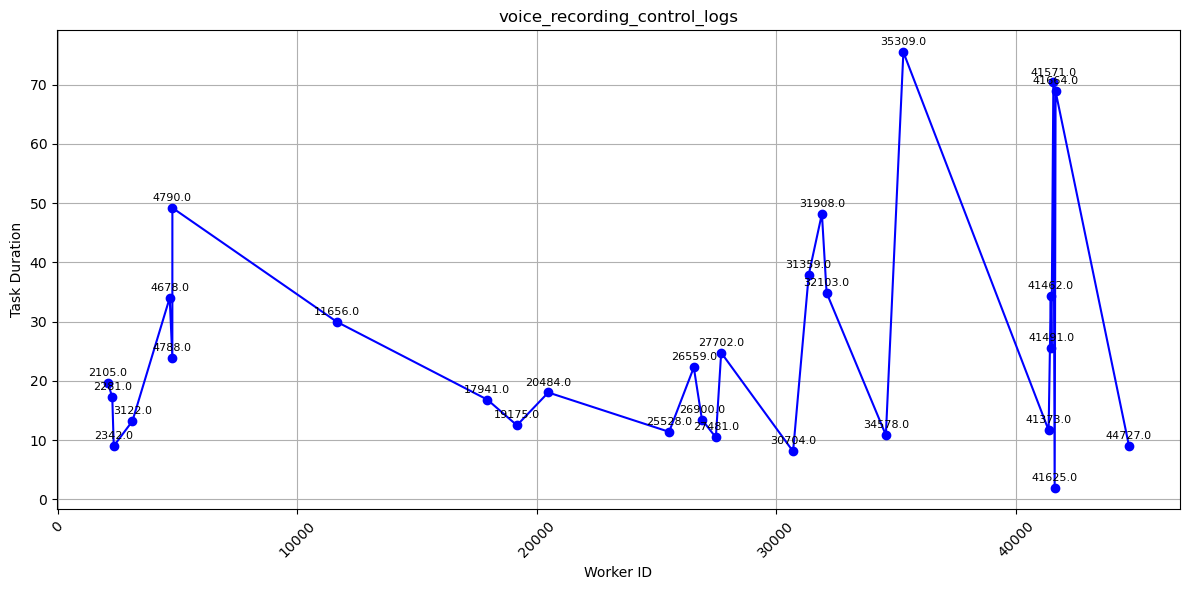

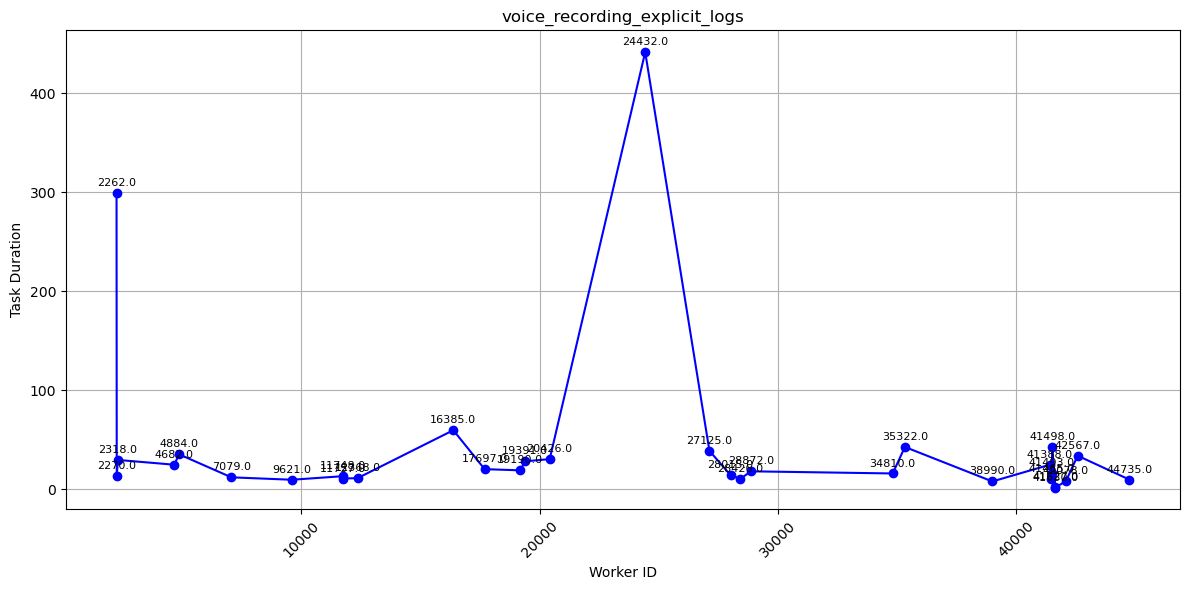

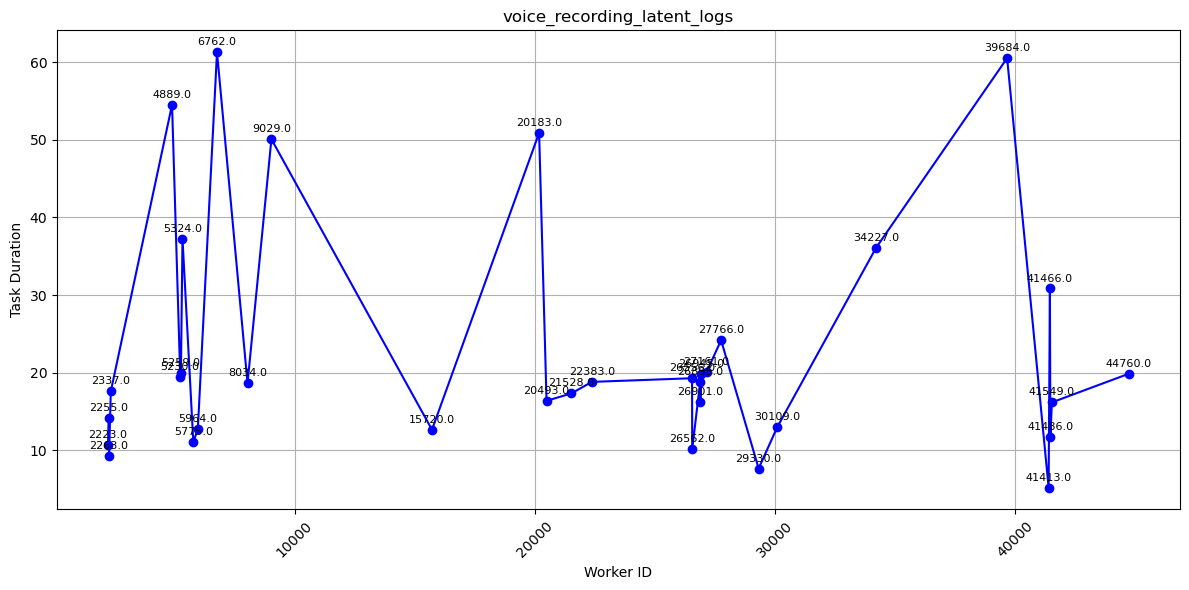

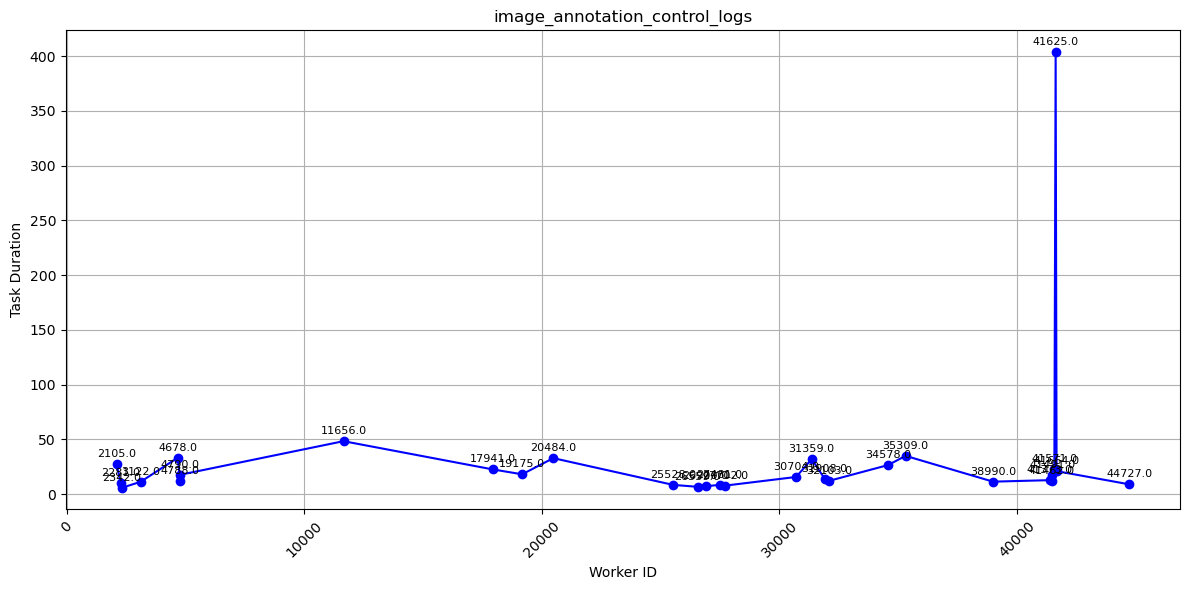

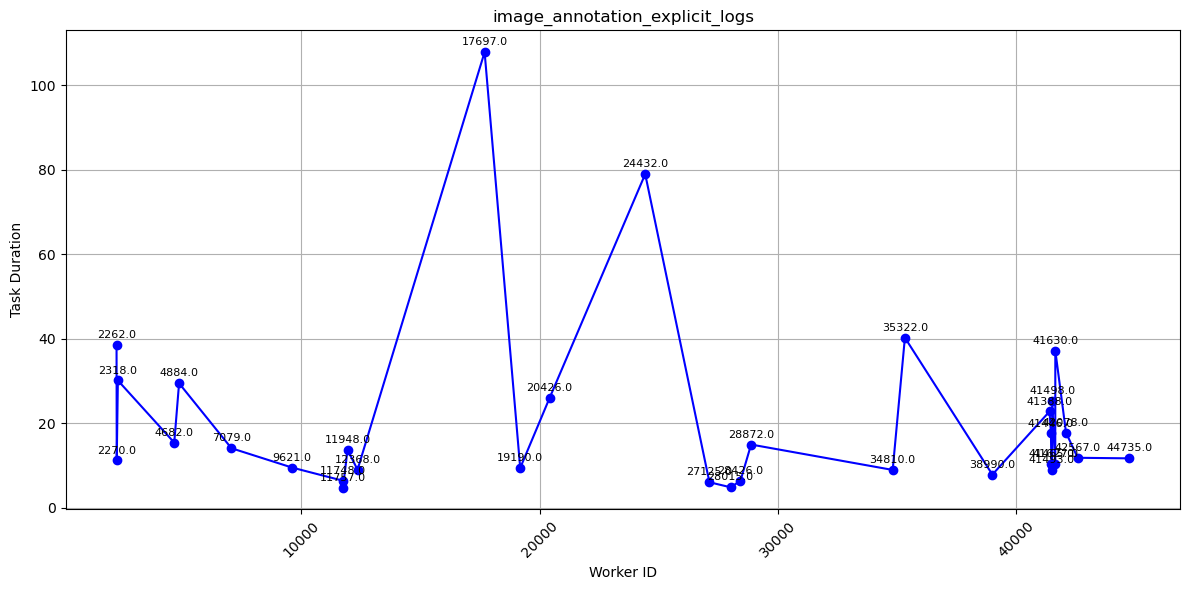

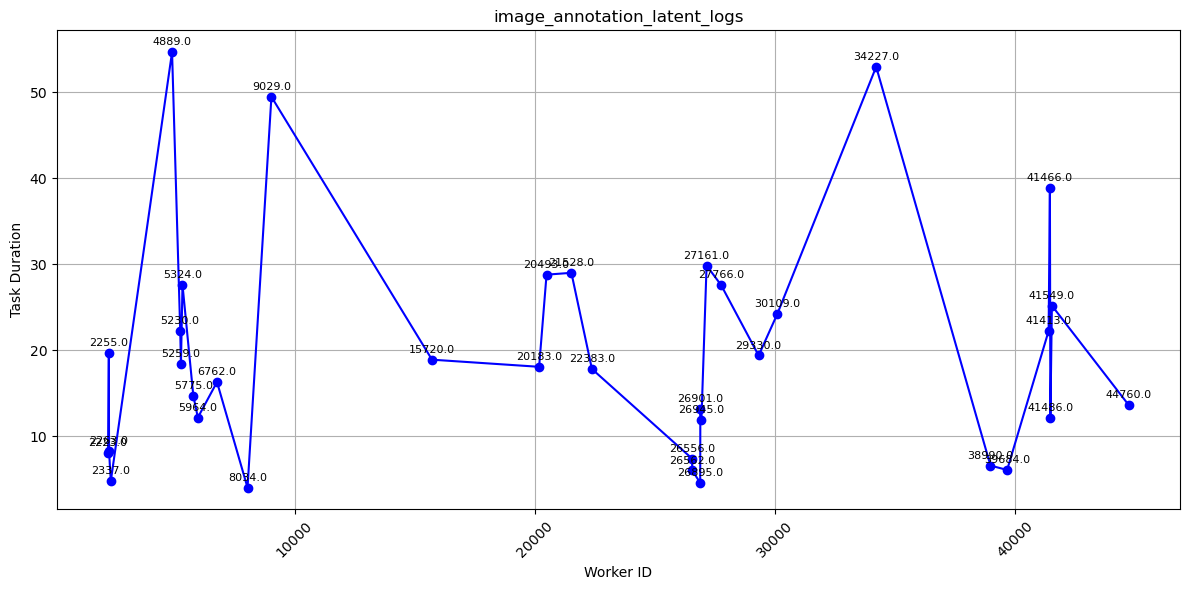

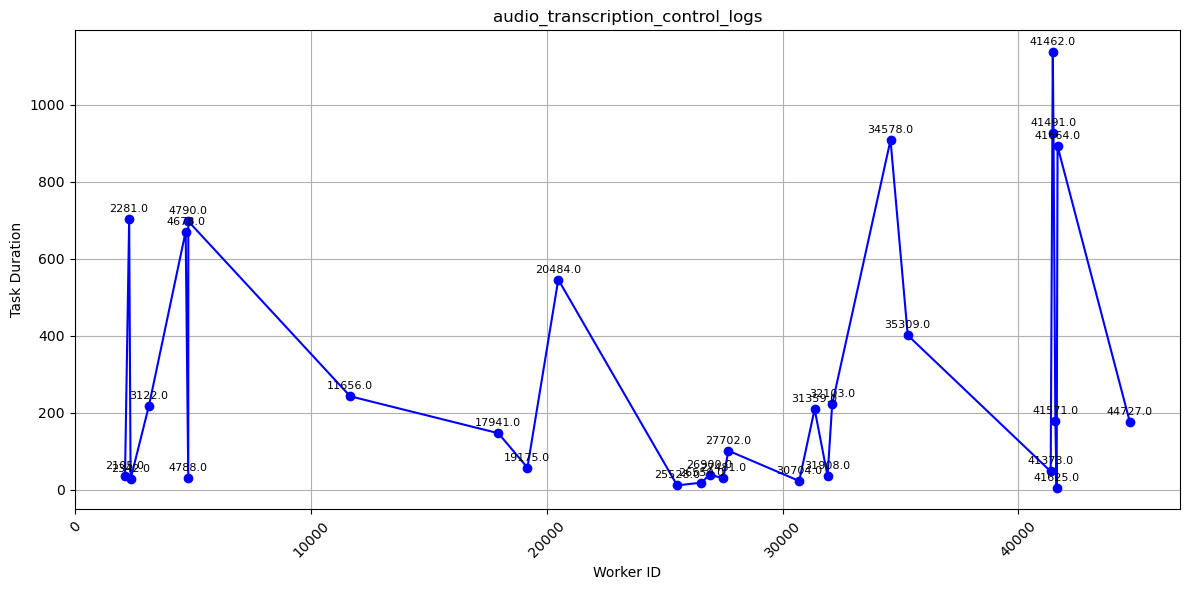

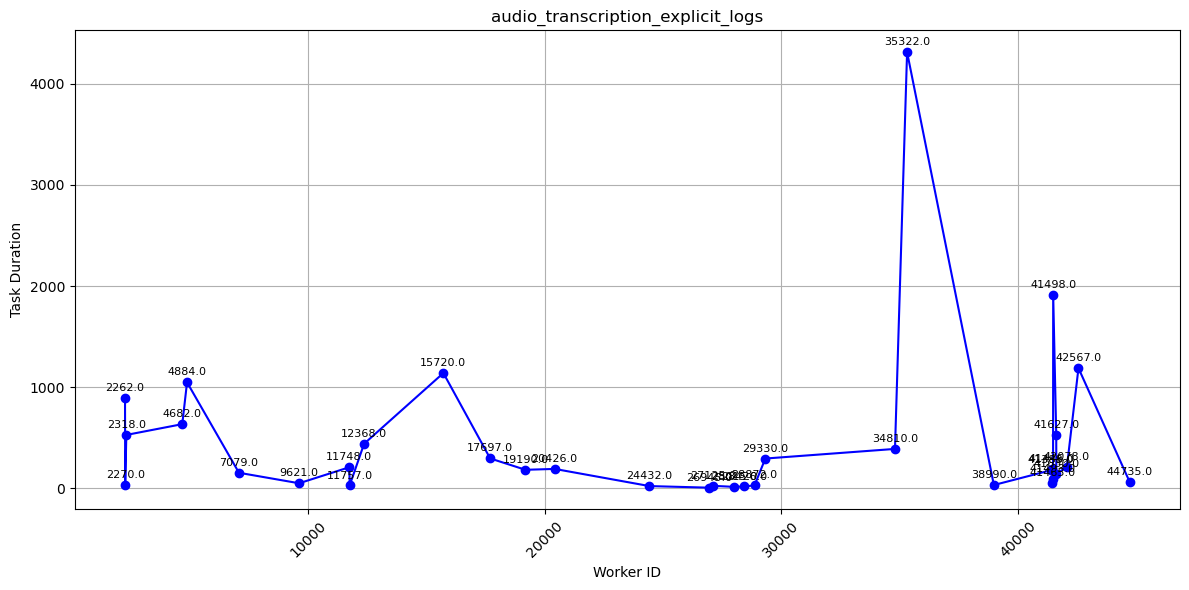

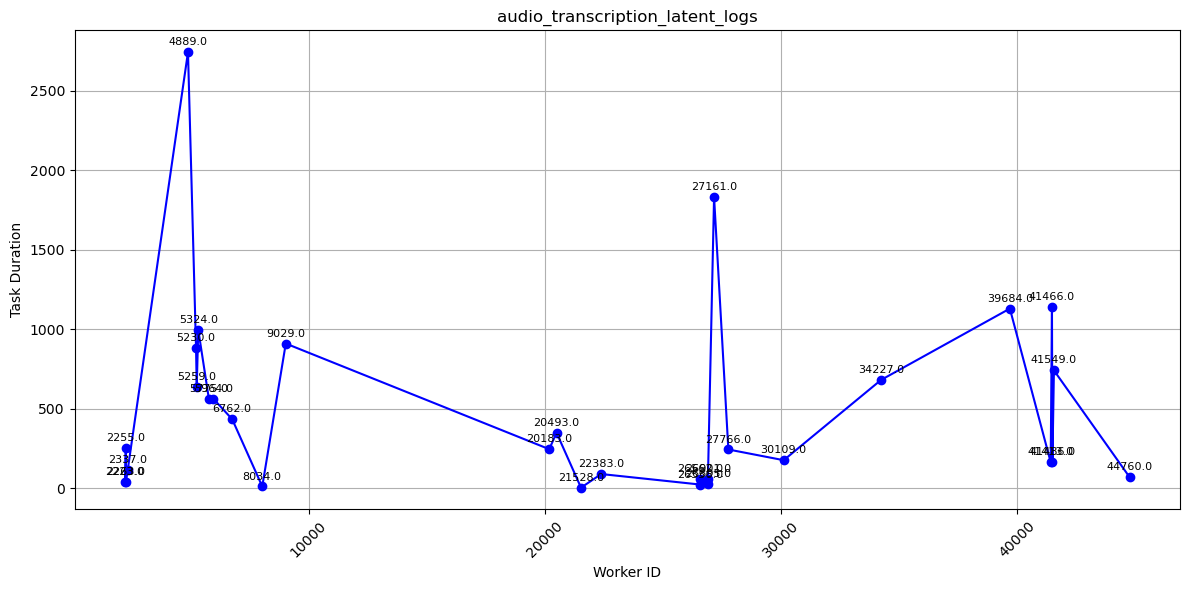

In [16]:
groups = ['control', 'explicit', 'latent']
tasks = ['voice_recording', 'image_annotation', 'audio_transcription']

for task in tasks:
    for group in groups:
        file_path = (f"{task}/{task}_{group}_logs.csv")
        calculate_average_duration(file_path)